In [63]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width to display everything
pd.set_option('display.max_colwidth', None)  # Show full column content

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from wordcloud import WordCloud , STOPWORDS

import emoji
import re

from collections import Counter

import plotly.graph_objs as go
from plotly.offline import iplot

import plotly.express as px

In [3]:
twitter_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\twitter_cleaned_data.csv")

In [4]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014005 entries, 0 to 1014004
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   created_at            1014005 non-null  object
 1   tweet_id              1014005 non-null  int64 
 2   tweet                 1014005 non-null  object
 3   likes                 1014005 non-null  int64 
 4   retweet_count         1014005 non-null  int64 
 5   source                1014002 non-null  object
 6   user_id               1014005 non-null  int64 
 7   user_join_date        1014005 non-null  object
 8   user_followers_count  1014005 non-null  int64 
 9   user_location         1009904 non-null  object
 10  city                  1014005 non-null  object
 11  state                 1014005 non-null  object
 12  candidate             1014005 non-null  object
 13  tweet_cleaned         1014005 non-null  object
 14  country               1014005 non-null  object
dty

In [5]:
twitter_df["created_at"] = pd.to_datetime(twitter_df["created_at"])
twitter_df["user_join_date"] = pd.to_datetime(twitter_df["user_join_date"])

In [12]:
# Fill null location columns with "unknown"
twitter_df["user_location"] = twitter_df["user_location"].fillna("unknown")

In [13]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014005 entries, 0 to 1014004
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   created_at            1014005 non-null  datetime64[ns]
 1   tweet_id              1014005 non-null  int64         
 2   tweet                 1014005 non-null  object        
 3   likes                 1014005 non-null  int64         
 4   retweet_count         1014005 non-null  int64         
 5   source                1014002 non-null  object        
 6   user_id               1014005 non-null  int64         
 7   user_join_date        1014005 non-null  datetime64[ns]
 8   user_followers_count  1014005 non-null  int64         
 9   user_location         1014005 non-null  object        
 10  city                  1014005 non-null  object        
 11  state                 1014005 non-null  object        
 12  candidate             1014005 non-null  ob

# Sentiment and WordCloud Analysis

In [15]:
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [16]:
# Apply sentiment analysis to the 'tweet_cleaned' column
twitter_df['sentiment'] = twitter_df['tweet_cleaned'].apply(get_sentiment)

In [20]:
# Group by candidate and sentiment to get the counts
sentiment_by_candidate = twitter_df.groupby(['candidate', 'sentiment']).size().unstack(fill_value=0)
print(sentiment_by_candidate)

sentiment  negative  neutral  positive
candidate                             
biden         68297   189805    159761
trump        131838   273214    191090


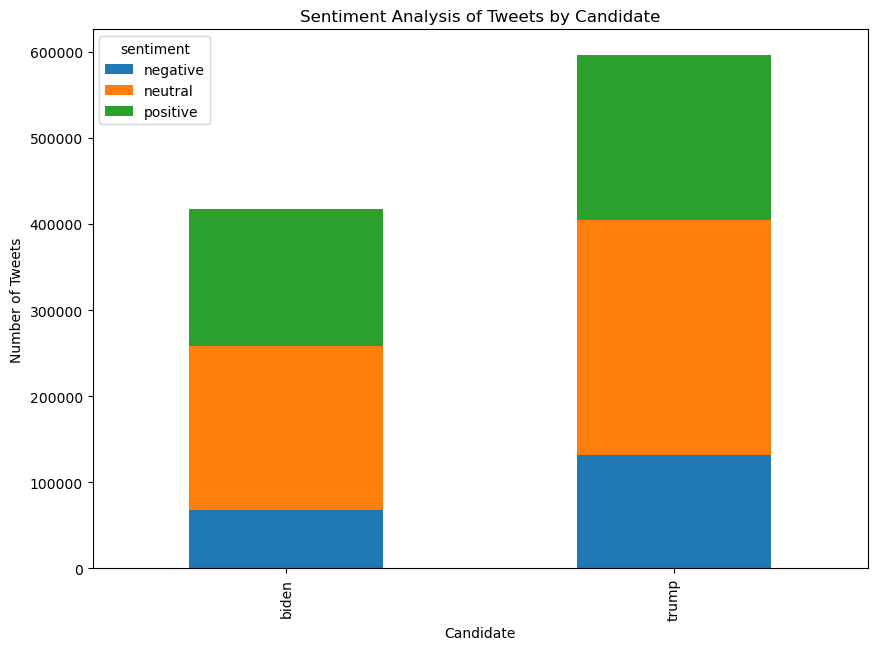

In [21]:
# Plotting sentiment distribution for each candidate
sentiment_by_candidate.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Sentiment Analysis of Tweets by Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.show()

In [29]:
# Group by candidate and sentiment to get the counts
proportion_sentiment_by_candidate = twitter_df.groupby('candidate')["sentiment"].value_counts(normalize=True).unstack(fill_value=0)
print(proportion_sentiment_by_candidate)

sentiment  negative   neutral  positive
candidate                              
biden      0.163444  0.454228  0.382329
trump      0.221152  0.458304  0.320544


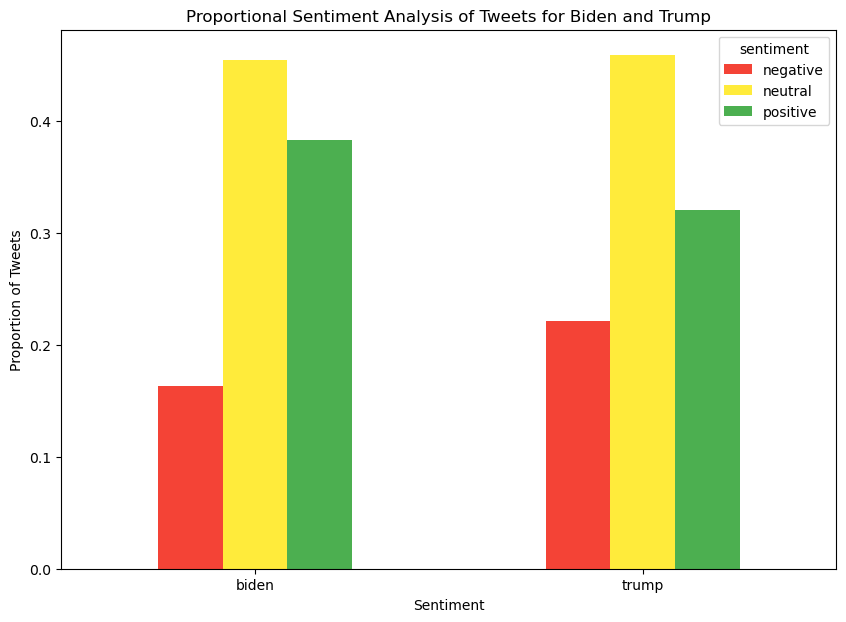

In [34]:
# Plot the proportional sentiment analysis
proportion_sentiment_by_candidate.plot(kind='bar', figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Proportional Sentiment Analysis of Tweets for Biden and Trump')
plt.xlabel('Sentiment')
plt.ylabel('Proportion of Tweets')
plt.xticks(rotation=0)
plt.show()

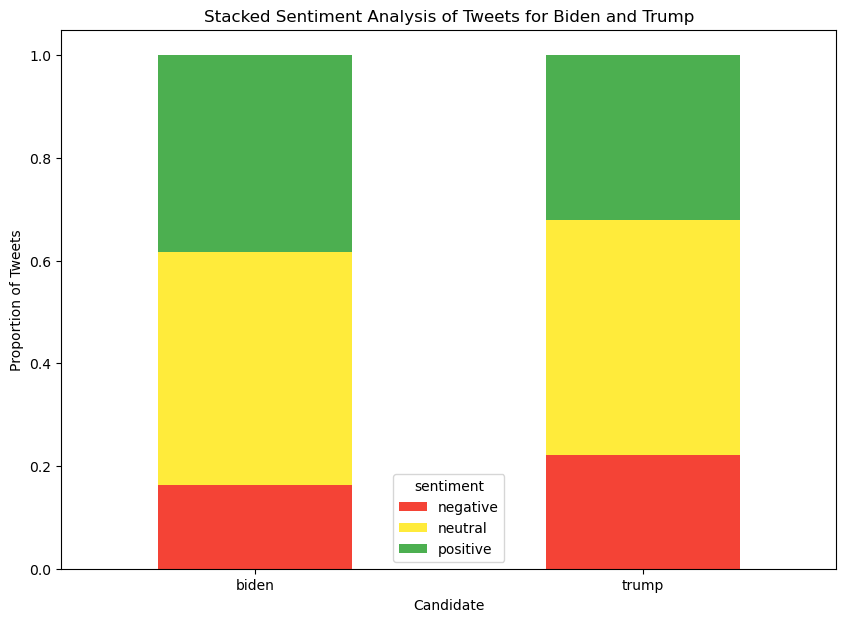

In [36]:
# Create a stacked bar plot for sentiment proportions
proportion_sentiment_by_candidate.plot(kind='bar', stacked=True, figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Stacked Sentiment Analysis of Tweets for Biden and Trump')
plt.xlabel('Candidate')
plt.ylabel('Proportion of Tweets')
plt.xticks(rotation=0)
plt.show()

In [47]:
biden_df = twitter_df[twitter_df['candidate']=='biden']
trump_df = twitter_df[twitter_df['candidate']=='trump']

In [48]:
# Create a column with date only (without time)
twitter_df["created_at_date"] = twitter_df["created_at"].dt.date

# Group by date and sentiment for both datasets
biden_sentiment_over_time = biden_df.groupby(['created_at_date', 'sentiment']).size().unstack(fill_value=0)
# Group by date and sentiment for both datasets
trump_sentiment_over_time = trump_df.groupby(['created_at_date', 'sentiment']).size().unstack(fill_value=0)

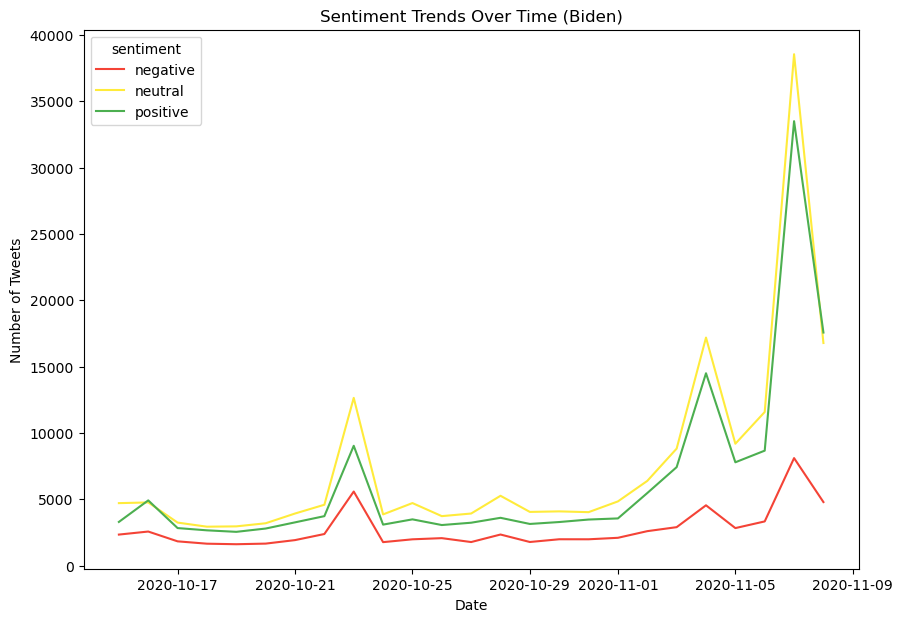

In [49]:
# Plot sentiment trends for Biden
biden_sentiment_over_time.plot(kind='line', figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Sentiment Trends Over Time (Biden)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

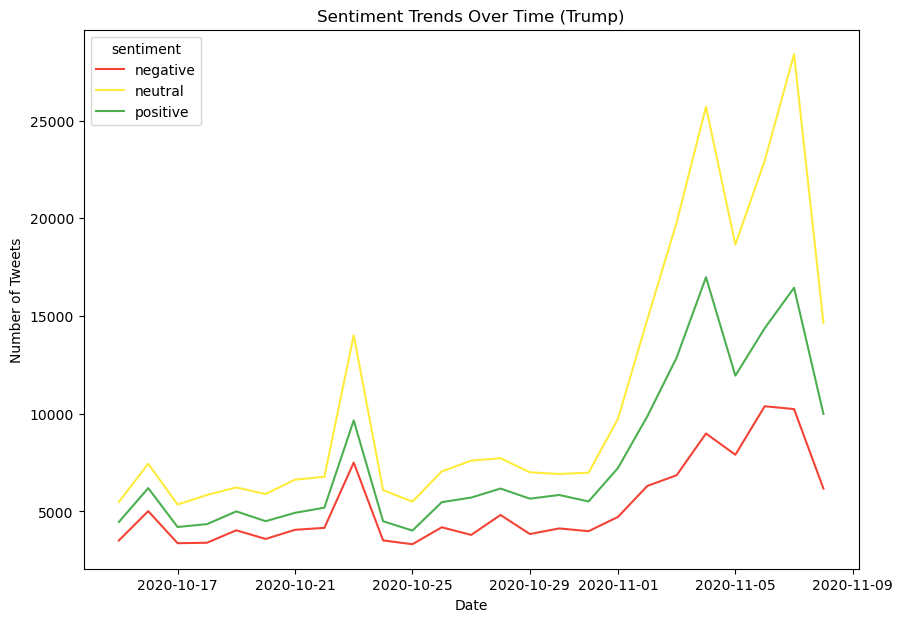

In [50]:
# Plot sentiment trends for Trump
trump_sentiment_over_time.plot(kind='line', figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Sentiment Trends Over Time (Trump)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

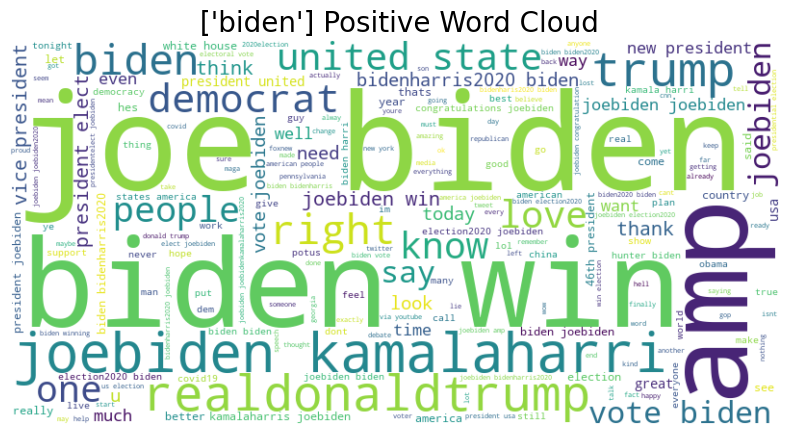

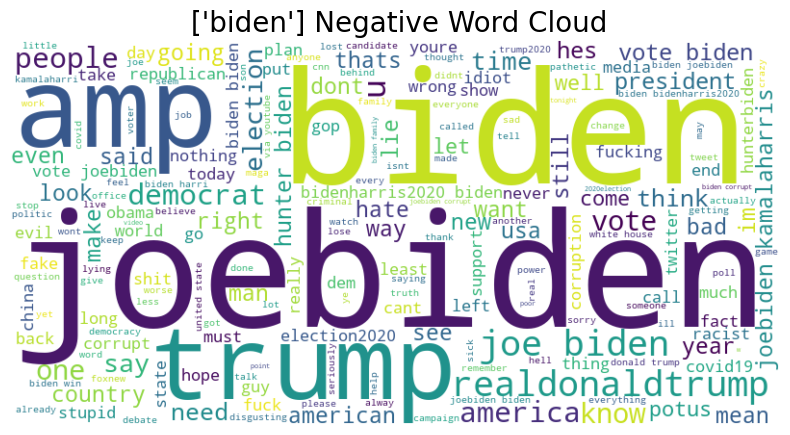

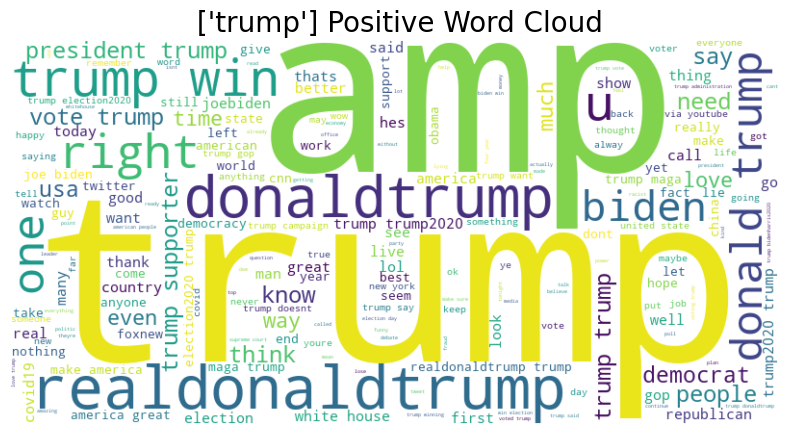

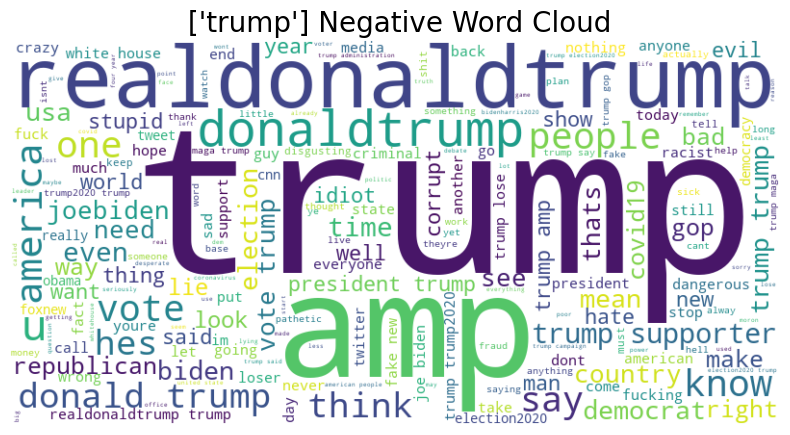

In [61]:
# Function to generate word cloud for a particular sentiment
def generate_wordcloud(df, sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['tweet_cleaned'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f' {df['candidate'].unique()} {sentiment.capitalize()} Word Cloud', fontsize=20)
    plt.show()

# Generate word clouds for positive and negative tweets for Biden
generate_wordcloud(biden_df, 'positive')
generate_wordcloud(biden_df, 'negative')

# Generate word clouds for positive and negative tweets for Trump
generate_wordcloud(trump_df, 'positive')
generate_wordcloud(trump_df, 'negative')

In [76]:
# Group by state and sentiment to get counts
biden_sentiment_by_state = biden_df[(biden_df['country']=='united states')&(biden_df['state']!='unknown')].groupby(['state', 'sentiment']).size().unstack(fill_value=0)
trump_sentiment_by_state = trump_df[(trump_df['country']=='united states')&((trump_df['state']!='unknown'))].groupby(['state', 'sentiment']).size().unstack(fill_value=0)

In [77]:
trump_sentiment_by_state

sentiment,negative,neutral,positive
state,,,
alabama,144,287,248
alaska,44,96,111
arizona,554,897,864
arkansas,117,237,146
california,6182,11486,7761
colorado,905,1105,1047
connecticut,187,495,256
delaware,29,102,45
district of columbia,1682,2957,2319


# Emoji Analysis

In [125]:
# Extract all emojis from tweet column and append to a list
all_emojis_list = []

recognized_emojis = set(emoji.EMOJI_DATA.keys())

for tweet in twitter_df['tweet']:
    for char in tweet:
        if char in recognized_emojis:
            all_emojis_list.append(char)

In [109]:
# Extract all emojis from tweet column and append to a list
all_emojis_list = []

for tweet in twitter_df['tweet']:
    for char in tweet:
        if char in emoji.EMOJI_DATA:
            all_emojis_list.append(char)

In [126]:
all_emojis_list

['💪',
 '🏽',
 '🤪',
 '🍔',
 '🍔',
 '🍔',
 '🎃',
 '😩',
 '🤚',
 '😬',
 '🤢',
 '👇',
 '👇',
 '👇',
 '👇',
 '🎶',
 '🎶',
 '🎶',
 '👉',
 '🏾',
 '👉',
 '🏾',
 '👉',
 '🏾',
 '👉',
 '🏾',
 '👉',
 '🏾',
 '™',
 '🚨',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '‼',
 '🚨',
 '‼',
 '👱',
 '🦅',
 '🦅',
 '🧓',
 '🧑',
 '🦳',
 '📸',
 '🎖',
 '👲',
 '🎖',
 '👩',
 '🦯',
 '🧑',
 '🦯',
 '👩',
 '🦽',
 '👨',
 '🦼',
 '👩',
 '🦽',
 '💯',
 '⬇',
 '☠',
 '🤮',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '🤮',
 '🖕',
 '🏻',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '👇',
 '🚨',
 '😂',
 '😂',
 '👏',
 '👏',
 '👏',
 '💪',
 '💪',
 '🏽',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '🤔',
 '🤔',
 '🤔',
 '😳',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '☠',
 '💀',
 '😎',
 '🥰',
 '😡',
 '😡',
 '😡',
 '🤦',
 '🏻',
 '♀',
 '😳',
 '😆',
 '🙄',
 '🚫',
 '🚫',
 '😷',
 '🤒',
 '👌',
 '💊',
 '😇',
 '‼',
 '🚨',
 '‼',
 '👇',
 '👇',
 '👇',
 '😱',
 '😱',
 '😱',
 '😱',
 '😱',
 '😱',
 '😱',
 '😱',
 '😂',
 '🖤',
 '🖤',
 '🖤',
 '😏',
 '‼',
 '💁',
 '♂',
 '🦠',
 '🦠',
 '🦠',
 '🦠',
 '🦠',
 '🦠',
 '🦠',
 '🤡',
 '🤡',
 '🤡',
 '🤡',
 '🤡',
 '🤡',
 '🤡',
 '🤡'

In [135]:
# Count top 10 emoji frequency
Counter(all_emojis_list).most_common(10)

[('😂', 35599),
 ('🤣', 24763),
 ('💙', 19378),
 ('🌊', 13040),
 ('❤', 11661),
 ('👏', 11566),
 ('🏻', 11164),
 ('👇', 11069),
 ('🙏', 9169),
 ('🏼', 7341)]

In [136]:
# Extract only the emojis from the top 10 list
emojis = [Counter(all_emojis_list).most_common(10)[i][0] for i in range(10)]

In [137]:
# Extract only the frequency from the top 10 list
freqs = [Counter(all_emojis_list).most_common(10)[i][1] for i in range(10)]

In [144]:
iplot([go.Bar(x=emojis , y=freqs)])

# Feature Engineering

In [150]:
# Create a new column for the number of days between 'created_at' and 'user_join_date'
twitter_df['days_between'] = (twitter_df['created_at'] - twitter_df['user_join_date']).dt.days

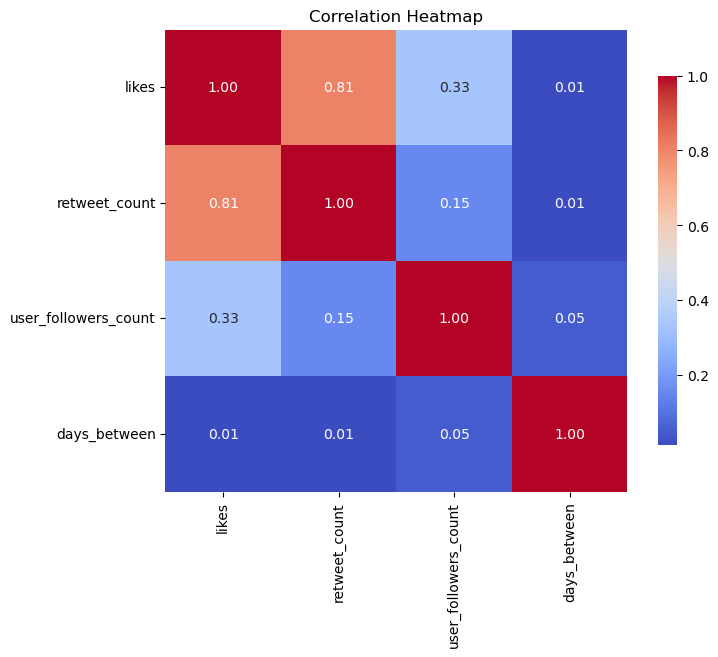

In [151]:
# Calculate the correlation matrix
correlation_matrix = twitter_df[['likes', 'retweet_count', 'user_followers_count', 'days_between']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()